In [2]:
# Author: Matteo Serafino, 2023
#
# This notebook focuses on the analyses presented in Section One of the reference paper.
# 
# Before proceeding, make sure to run "section_one_b_utilities.py" which creates part
# of the necessary files for the analyses.

In [3]:
import networkx as nx
import pandas as pd
import random
import numpy as np 
import pickle
import graph_tool.all as gt
import json
from scipy import stats
from collections import defaultdict
from tqdm import tqdm

from general_utilities import build_CI_rank,nx2gt,add_CI_to_graph

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams

font = {'size'   : 18}
rc('font', **font)

media_types = ['fake', 'far_right', 'right', 'lean_right',
               'center', 'lean_left', 'left','far_left']
    
    
abbr_to_good={'far_right':'Extreme bias right',
              'fake':'Fake','right':'Right',
              'center':'Center','lean_left':'Left leaning',
              'left':'Left','lean_right':'Right leaning',
              'far_left':'Extreme bias Left'}

#TO DO: improve this part
import sys
sys.path.append('/home/matteo/IRA_paper/fake_news_during_election/')


from fake_identify import Are_you_IRA

putin = Are_you_IRA()


##
gran_path = '/sdf/MatteoPaper/'
section1_data_path = gran_path + 'section_one/' 
categories_net = gran_path + 'categories_networks/'

#import users accouns info
users_account = json.load(open(section1_data_path+'users_accounts.txt'))
users = pd.read_csv(section1_data_path+"all_users.csv", index_col="user_id",
                    usecols =["user_id", "is_IRA"], dtype={"user_id": str, "is_IRA": int})
IRA = users[users.is_IRA > 0]
IRA = set([int(i) for i in IRA.index if len(i)!=64])

Suspended = set([int(i) for i in users_account if (users_account[i]=='Suspended' and int(i) not in IRA)])
Not_Found = set([int(i) for i in users_account if (users_account[i]=='Not found' and int(i) not in IRA)])
Verified = set([int(i) for i in users_account if( users_account[i]=='Verified' and int(i )not in IRA)])
Not_Verified = set([int(i) for i in users_account if (users_account[i]=='Not verified' and int(i) not in IRA)])


from palettable.cartocolors.diverging import Geyser_7_r as colormap
mediacolors = colormap.mpl_colors
mediacolors.insert(0, (0.5,0.5,0.5))

def darker(color, percent):
    '''assumes color is rgb between (0, 0, 0) and (1, 1, 1)'''
    color = np.array(color)
    black = np.array([0, 0, 0])
    vector = black-color
    return color + vector * percent

colors={}
mediacolors_bb = mediacolors[:]
mediacolors_bb.insert(1, mediacolors[1])
mediacolors_bb.insert(-1, mediacolors[-1])
index=['Fake','Extreme bias right','Right','Right leaning','Center','Left leaning','Left','Extreme bias Left']
for name, color in zip(index,
        mediacolors_bb):
    colors[name] = list(darker(color,0.2)) + [1.0]

In [4]:
def get_G_char(g_file,
               n_nodes_i,
               rand=False,
               sample=1000,
               category=None,
               typology = None):
    
    #print(g_file, "...")
    G =  gt.load_graph(categories_net+"retweet_graph_{}_simple_june-nov.gt".format(g_file))
    k_in = {i:j for i, j in zip(G.vertex_properties["user_id"],G.vertex_properties["k_in"])}
    k_out = {i:j for i, j in zip(G.vertex_properties["user_id"],G.vertex_properties["k_out"])}
    
    category_all = set(list(G.vp['user_id'])) 
    
    if category: 
        category_all = list(set(category_all) & set(category))
    
    if typology:
        nodes = set([uid for uid in typology if (uid in category_all)])
        n_nodes = len(nodes)
        
        out_d = pd.Series([k_out[n] for n in nodes])
        ave_k_out = out_d.sum() / n_nodes

        in_d = pd.Series([k_in[n] for n in nodes])
        ave_k_in = in_d.sum() / n_nodes

        return {"N nodes": int(n_nodes),
                "<k_out>": ave_k_out,
                "<k_in>": ave_k_in}
    
    if rand:
        ave_k_out,ave_k_in=0,0
        out_d,in_d=0,0
        category_all_2 = set(category_all)
        outt =[]
        inn =[]
        for cnt in range(sample):
            if not category:
                set_n=random.sample(category_all,n_nodes_i)
            else:
                
                set_n=random.sample(category_all,n_nodes_i)
                
            nodes = set([uid for uid in set_n if uid in category_all_2])
            n_nodes = len(nodes)

            out_d = pd.Series([k_out[n] for n in nodes])
            ave_k_out += out_d.sum() / n_nodes

            in_d = pd.Series([k_in[n] for n in nodes])
            ave_k_in += in_d.sum() / n_nodes
            
            outt.append(out_d.sum() / n_nodes)
            inn.append(in_d.sum() / n_nodes)

        return {
        "<k_out>": ave_k_out/sample,
        "std_out": np.std(outt)/np.sqrt(len(outt)),
        "<k_in>": ave_k_in/sample,
        "std_in": np.std(inn)/np.sqrt(len(inn))}
    else:
        print(g_file, "...")
        n_nodes = len(category_all)
        n_edges = len(list(G.edges()))
        k = n_edges / n_nodes

        out_d = list(k_out.values())
        # print(out_d)
        ave_out_d = sum(out_d)/ n_nodes

        in_d = list(k_in.values())
        # print(in_d)
        ave_in_d = sum(in_d)/ n_nodes


        return {
            "N nodes": int(n_nodes),
            "N edges": int(n_edges),
            "<k_out>": ave_out_d,
            "<k_in>": ave_in_d}        

In [5]:
#upload the neworks per catgory
networks_char= {}
for category in media_types:
    rst = get_G_char(category,'None')
    networks_char[category] = rst
    
networks_char = pd.DataFrame(networks_char).round(1).transpose()
networks_char = networks_char.astype({
    "N nodes": int,
    "N edges": int,
})
pd.to_pickle(networks_char, section1_data_path +"categories_degree.csv")

fake ...
far_right ...
right ...
lean_right ...
center ...
lean_left ...
left ...
far_left ...


In [6]:
#find the group degree
tables={}
for typology,nm in zip([Suspended,Not_Found,Verified,Not_Verified,IRA],
                   ['Suspended','Not Found','Verified','Not Verified','IRA']):
    print(nm+'...')
    networks_char_T = {}
    for category in media_types:
        rst = get_G_char(category,'None',typology=typology)
        networks_char_T[category] = rst

    networks_char_T = pd.DataFrame(networks_char_T).round(1).transpose()
    networks_char_T = networks_char_T.astype({
        "N nodes": int,
    })

    tables[nm] = networks_char_T

pd.to_pickle(tables, section1_data_path +"groups_degree.pickle")


Suspended...
Not Found...
Verified...
Not Verified...
IRA...


In [7]:
#sampling bias test
networks_char_s = {}
for tps,nm in zip([Suspended,Not_Found,Verified,Not_Verified],
                  ['Suspended','Not Found','Verified','Not Verified']):
    networks_char_s_ = {}
    print(nm+'...')
    for category in media_types:
        n_nodes_i=int(tables['IRA'].loc[category]['N nodes'])
        rst = get_G_char(category,n_nodes_i,rand=True,category = tps)
        networks_char_s_[category] = rst
    networks_char_s[nm] = pd.DataFrame(networks_char_s_).T
networks_char_s['IRA'] = tables['IRA'].drop(columns=['N nodes'])
pd.to_pickle(networks_char_s, section1_data_path +"sampled_degree.pickle")

Suspended...
Not Found...
Verified...
Not Verified...


In [8]:
#tabel 1 main paper
networks_chars = {}
networks_chars['Full Network'] = networks_char.rename(index=abbr_to_good).drop(columns = '<k_out>')
networks_chars['IRA'] = tables['IRA'].rename(index=abbr_to_good)
pd.concat(networks_chars,axis=1).round(1)

Full Network                     IRA               
                        N nodes  N edges <k_in> N nodes <k_out> <k_in>
Fake                     175605  1143083    6.5      54    32.5    5.4
Extreme bias right       249659  1637927    6.6      70    27.3    7.1
Right                    345644  1797023    5.2      84    30.1    4.7
Right leaning            216026   495307    2.3      67     6.3    1.7
Center                   864733  2501037    2.9     163     4.6    2.6
Left leaning            1043436  3570653    3.4     140     8.9    2.2
Left                     536903  1801658    3.4     105     4.3    2.4
Extreme bias Left         78911   277483    3.5      10     0.0    1.6

In [9]:
#table main paper tab2
print(pd.concat(networks_chars,axis=1).round(1).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Full Network} & \multicolumn{3}{l}{IRA} \\
{} &      N nodes &  N edges & <k\_in> & N nodes & <k\_out> & <k\_in> \\
\midrule
Fake               &       175605 &  1143083 &    6.5 &      54 &    32.5 &    5.4 \\
Extreme bias right &       249659 &  1637927 &    6.6 &      70 &    27.3 &    7.1 \\
Right              &       345644 &  1797023 &    5.2 &      84 &    30.1 &    4.7 \\
Right leaning      &       216026 &   495307 &    2.3 &      67 &     6.3 &    1.7 \\
Center             &       864733 &  2501037 &    2.9 &     163 &     4.6 &    2.6 \\
Left leaning       &      1043436 &  3570653 &    3.4 &     140 &     8.9 &    2.2 \\
Left               &       536903 &  1801658 &    3.4 &     105 &     4.3 &    2.4 \\
Extreme bias Left  &        78911 &   277483 &    3.5 &      10 &     0.0 &    1.6 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_22178/2201391715.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(networks_chars,axis=1).round(1).to_latex())


In [10]:
#table main paper tab2
print(pd.concat(networks_char_s,axis=1).rename(index=abbr_to_good).round(1).to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{Suspended} & \multicolumn{4}{l}{Not Found} & \multicolumn{4}{l}{Verified} & \multicolumn{4}{l}{Not Verified} & \multicolumn{2}{l}{IRA} \\
{} &   <k\_out> & std\_out & <k\_in> & std\_in &   <k\_out> & std\_out & <k\_in> & std\_in &  <k\_out> & std\_out & <k\_in> & std\_in &      <k\_out> & std\_out & <k\_in> & std\_in & <k\_out> & <k\_in> \\
\midrule
Fake               &      12.0 &     1.2 &    9.7 &    0.1 &       3.4 &     0.4 &    6.1 &    0.1 &    221.9 &     8.8 &    1.7 &    0.0 &          3.9 &     0.5 &    5.6 &    0.1 &    32.5 &    5.4 \\
Extreme bias right &       7.2 &     0.6 &    8.7 &    0.1 &       3.1 &     0.3 &    6.4 &    0.1 &    276.1 &     9.0 &    2.2 &    0.0 &          4.2 &     0.5 &    5.8 &    0.1 &    27.3 &    7.1 \\
Right              &       4.2 &     0.3 &    7.5 &    0.1 &       2.0 &     0.2 &    5.3 &    0.0 &    190.5 &     7.3 &    2.1 &    0.0 &          2.4 &     0.2 &    4.5 

/tmp/ipykernel_22178/3654781838.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(networks_char_s,axis=1).rename(index=abbr_to_good).round(1).to_latex())


In [11]:
#tab supp material
#table main paper tab2
print(pd.concat(tables,axis=1).rename(index=abbr_to_good).round(1).to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Suspended} & \multicolumn{3}{l}{Not Found} & \multicolumn{3}{l}{Verified} & \multicolumn{3}{l}{Not Verified} & \multicolumn{3}{l}{IRA} \\
{} &   N nodes & <k\_out> & <k\_in> &   N nodes & <k\_out> & <k\_in> &  N nodes & <k\_out> & <k\_in> &      N nodes & <k\_out> & <k\_in> & N nodes & <k\_out> & <k\_in> \\
\midrule
Fake               &     35490 &    11.2 &    9.7 &     38262 &     3.2 &    6.1 &      661 &   217.0 &    1.7 &       101136 &     4.7 &    5.6 &      54 &    32.5 &    5.4 \\
Extreme bias right &     53741 &     7.4 &    8.8 &     51607 &     3.0 &    6.5 &     1996 &   267.1 &    2.1 &       142241 &     3.9 &    5.8 &      70 &    27.3 &    7.1 \\
Right              &     60908 &     4.5 &    7.5 &     68260 &     2.0 &    5.3 &     4696 &   186.8 &    2.1 &       211680 &     2.4 &    4.6 &      84 &    30.1 &    4.7 \\
Right leaning      &     33378 &     1.7 &    3.1 &     37356 &     0.9 &    2.4 &  

/tmp/ipykernel_22178/1283656826.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(tables,axis=1).rename(index=abbr_to_good).round(1).to_latex())


# CI

In [12]:
print("loading all tweets_csv ...")
%time all_tweets = pd.read_csv(section1_data_path+"all_tweets.csv", dtype=str)
print("finished!")

loading all tweets_csv ...
CPU times: user 32 s, sys: 2.9 s, total: 34.9 s
Wall time: 47.8 s
finished!


In [13]:
all_tweets

,Unnamed: 0,tweet_id,user_id,type_,is_retweet,category
0,27,737881663938670592,16411611,Not Verified,1,fake
1,28,737886010047102976,192692803,Not Verified,1,fake
2,29,737889143196385282,448160125,Not Verified,1,fake
3,30,737889414068731904,40334543,Not Found,1,fake
4,31,737897742324928512,51339157,Suspended,0,fake
...,...,...,...,...,...,...
30829128,609580,796161977827594240,1022580570,Not Verified,0,far_left
30829129,609581,796192436347342849,630044226,Not Verified,0,far_left
30829130,609582,796201949020319745,160029428,Not Verified,0,far_left
30829131,609583,796205479894466560,3034626213,Suspended,0,far_left


In [14]:
p0 = []
index = []
categories = []
for i in pd.unique(all_tweets['type_']):
    if i != 'None':
        index.append(i)
        temp_=all_tweets[all_tweets.type_==i]
        p = []
        for category in pd.unique(all_tweets['category']):
            categories.append(category)
            temp_2=temp_[temp_['category']==category]
            p.append(len(temp_2[temp_2.is_retweet == '0'])/len(temp_))
        p0.append(p)

In [15]:
P =  pd.DataFrame(p0,columns=[abbr_to_good[i] for i in categories[:8]],index=index)

In [16]:
P = P.reindex([ 'Not Verified', 'Suspended','Not Found','Verified', 'IRA'])
P = P*100

In [17]:
P.sum(axis=1)

Not Verified    31.962948
Suspended       38.607387
Not Found       27.318290
Verified        71.172776
IRA             29.445844
dtype: float64

In [18]:
print(P.round(2).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Fake &  Extreme bias right &  Right &  Right leaning &  Center &  Left leaning &   Left &  Extreme bias Left \\
\midrule
Not Verified &  2.33 &                3.07 &   3.40 &           1.15 &    6.99 &          8.43 &   5.92 &               0.67 \\
Suspended    &  8.50 &                7.07 &   5.06 &           1.47 &    6.68 &          5.82 &   3.59 &               0.41 \\
Not Found    &  3.24 &                4.60 &   4.12 &           0.96 &    4.36 &          5.83 &   3.78 &               0.42 \\
Verified     &  0.49 &                3.06 &   7.08 &           3.17 &   19.98 &         25.48 &  10.95 &               0.96 \\
IRA          &  3.68 &                2.64 &   4.03 &           0.91 &    5.94 &         11.56 &   0.68 &               0.00 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_22178/1236210014.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(P.round(2).to_latex())


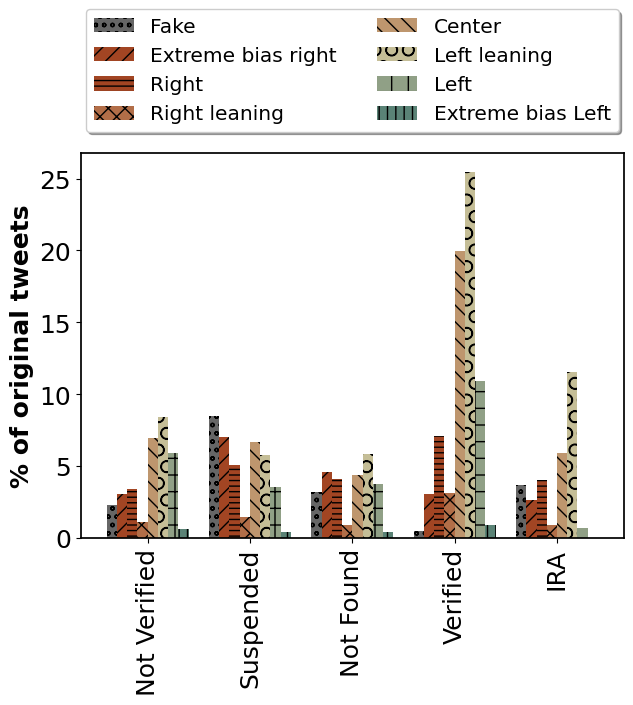

In [19]:
ax = P.plot(kind='bar',figsize=(7,5), width=0.8,legend=False,color=[colors[group] for group in P.columns])


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)

bars = ax.patches
hatches=[]
for i in ["oo","//","---","xx","\\\\","O","+","||"]:
    for _ in range(5):
        hatches.append(i)

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

plt.ylabel('% of original tweets',fontsize=18,fontweight='bold')

plt.xticks(rotation=90)

plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.4), shadow=True, ncol=2, prop={'size': 14.5})

plt.savefig('Figures/'+'Fig5.pdf',bbox_inches='tight')

plt.show()


# Plot the results for the paper

In [20]:
sampled_degree = pd.read_pickle(section1_data_path +"sampled_degree.pickle")

In [21]:
for i in sampled_degree['Not Verified']['std_in'].values:
    print('$\pm$',round(i,2))

$\pm$ 0.06
$\pm$ 0.06
$\pm$ 0.04
$\pm$ 0.01
$\pm$ 0.02
$\pm$ 0.03
$\pm$ 0.04
$\pm$ 0.09


In [ ]:
  & \multicolumn{2}{c|}{Suspended} & \multicolumn{2}{c|}{Not Found} & \multicolumn{2}{c|}{Verified} & \multicolumn{2}{c|}{Not Verified} & \multicolumn{2}{c|}{IRA} \\
  & $\langle k_{out}^s\rangle$  & $\langle k_{in}^s \rangle$ & $\langle k_{out}^s\rangle$  & $\langle k_{in}^s \rangle$ & $\langle k_{out}^s\rangle$  & $\langle k_{in}^s \rangle$ 
  & $\langle k_{out}^s\rangle$  & $\langle k_{in}^s \rangle$ & $\langle k_{out}^s\rangle$  & $\langle k_{in}^2 \rangle$ \\\hline
Fake               &      11.5 $\pm$ 0.79 &    9.6 $\pm$ 0.1 &       2.6 $\pm$ 0.22 &    6.0 $\pm$ 0.06 &    224.5 $\pm$ 8.56 &    1.7 $\pm$ 0.02 &          4.0 $\pm$ 0.86 &    5.5 $\pm$ 0.06 &    32.5 &    5.4 \\
Extreme bias right &       7.3 $\pm$ 0.48 &    8.7 $\pm$ 0.09 &       3.2 $\pm$ 0.23 &    6.5 $\pm$ 0.06 &    260.3 $\pm$ 8.67 &    2.2 $\pm$ 0.02 &          3.9 $\pm$ 0.63 &    5.8 $\pm$ 0.06 &    27.3 &    7.1 \\
Right              &       4.4 $\pm$ 0.28 &    7.4 $\pm$ 0.07 &       1.8 $\pm$ 0.2 &    5.2 $\pm$ 0.05 &    181.5 $\pm$ 7.56 &    2.1 $\pm$ 0.02 &          2.8 $\pm$ 0.22 &    4.6 $\pm$ 0.04 &    30.1 &    4.7 \\
Right leaning      &       1.9 $\pm$ 0.15 &    3.1 $\pm$ 0.02 &       0.7 $\pm$ 0.09 &    2.4 $\pm$ 0.01 &     49.2 $\pm$ 2.56 &    1.3 $\pm$ 0.01 &          0.9 $\pm$ 0.08 &    2.1 $\pm$ 0.01 &     6.3 &    1.7 \\
Center             &       1.3 $\pm$ 0.08 &    3.4 $\pm$ 0.02 &       0.7 $\pm$ 0.04 &    2.9 $\pm$ 0.02 &     81.1 $\pm$ 5.78 &    2.5 $\pm$ 0.01 &          0.7 $\pm$ 0.14 &    2.8 $\pm$ 0.02 &     4.6 &    2.6 \\
Left leaning       &       1.2 $\pm$ 0.07 &    3.7 $\pm$ 0.03 &       0.9 $\pm$ 0.06 &    3.2 $\pm$ 0.03 &     84.0 $\pm$ 4.16 &    3.3 $\pm$ 0.02 &          1.2 $\pm$ 0.42 &    3.4 $\pm$ 0.03 &     8.9 &    2.2 \\
Left               &       1.6 $\pm$ 0.1 &    3.4 $\pm$ 0.04 &       1.2 $\pm$ 0.1 &    3.0 $\pm$ 0.03 &     67.1 $\pm$ 3.03 &    2.1 $\pm$ 0.02 &          2.4 $\pm$ 0.1 &    3.4 $\pm$ 0.04 &     4.3 &    2.4 \\
Extreme bias Left  &       1.5 $\pm$ 0.22 &    2.6 $\pm$ 0.08 &       3.4 $\pm$ 0.44 &    3.1 $\pm$ 0.07 &    95.0 $\pm$ 10.5 &    2.0 $\pm$ 0.2 &          3.6 $\pm$ 0.22 &    3.9 $\pm$ 0.09 &     0.0 &    1.6 \\\hline

In [23]:
sampled_degree['Verified']

,<k_out>,std_out,<k_in>,std_in
fake,221.911056,8.784681,1.683056,0.017085
far_right,276.069071,8.964556,2.159129,0.020910
right,190.522964,7.344632,2.070119,0.016938
lean_right,43.467672,2.124195,1.275134,0.008194
center,80.446423,5.555513,2.497718,0.013254
lean_left,85.524029,4.059190,3.269886,0.021497
left,62.368219,2.494883,2.111495,0.018697
far_left,75.795900,8.783109,1.989000,0.205628


In [24]:
def compute_2stest_matrix(TABLE,degree = '<k_out>'):
    matrix = np.zeros((5,5))
    #KS test
    #Null Hypotesis: coming from same distr
    for cnt, line in enumerate(['Suspended','Not Found','Verified','Not Verified','IRA']):

        for cnt1, line2 in enumerate(['Suspended','Not Found','Verified','Not Verified','IRA']):
        
            pvalue = stats.ks_2samp(TABLE[line][degree].to_list(),
                                    TABLE[line2][degree].to_list()).pvalue
            if pvalue < 0.05:
                matrix[cnt,cnt1] = 1
            else:
                matrix[cnt,cnt1] = 0
    return matrix

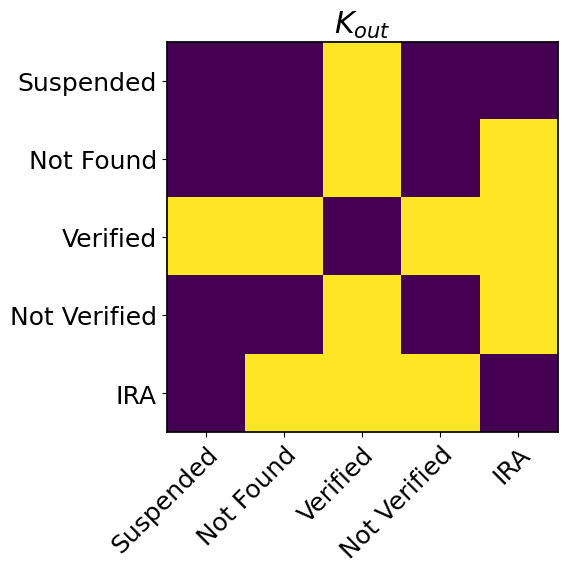

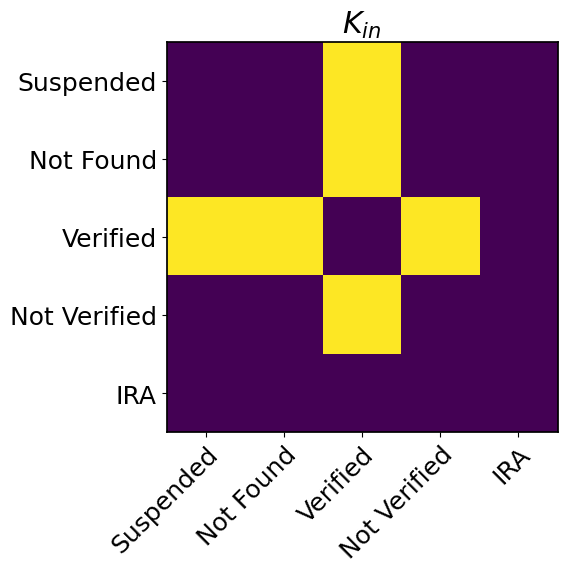

In [25]:
for degree in ['<k_out>','<k_in>']:
    matrix = compute_2stest_matrix(sampled_degree,degree = degree)

    fig, ax = plt.subplots(1,1,figsize=(6,6))

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.25)


    im = ax.imshow(matrix, interpolation='nearest')

    names = ['Suspended','Not Found','Verified','Not Verified','IRA']
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(names)), labels=names)
    ax.set_yticks(np.arange(len(names)), labels=names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fig.tight_layout()

    if degree ==  '<k_out>':
        ax.set_title("$K_{out}$")
        plt.savefig('Figures/'+'Fig4a.pdf',bbox_inches='tight')
    else:
        ax.set_title("$K_{in}$")
        plt.savefig('Figures/'+'Fig4b.pdf',bbox_inches='tight')
    
    plt.show()

In [26]:
#Top 100 sampled influencers

In [27]:
final_tab = {}
for direction in ['in','out']:
    rankig_infleuncers = {}
    for media in  media_types:
        rankig_infleuncers[media] = {}
        media_r = json.load(open(section1_data_path+f'sampled_influencers_{media}.txt'))
        for key in media_r:
            rankig_infleuncers[media][key]= int(np.mean(media_r[key][direction]))
    tab =  pd.DataFrame(rankig_infleuncers).T   
    final_tab[direction] = tab

In [28]:
pd.concat(final_tab,axis=1).rename(index=abbr_to_good)

in                                              out  \
                     IRA Suspended Not Found Verified Not Verified    IRA   
Fake                 267        85       449    15216          597    140   
Extreme bias right   104        98       428    11076          667    156   
Right                 87        42       282     6349          420    103   
Right leaning        101         3        14      345           22    206   
Center               196        72       182      699          202    440   
Left leaning        1693       539       799     1463          860    534   
Left                3088       895      1415     4800         1070   1058   
Extreme bias Left   8458     12659      6882    20845         6455  55814   

                                                              
                   Suspended Not Found Verified Not Verified  
Fake                    1284      4140       93         4215  
Extreme bias right      1970      3830       38         4258  
Right                   1988      3983       47         3841  
Right leaning           2226      4156       57         3591  
Center                  4501      6367       45         6329  
Left leaning            6973      9910       92         9559  
Left                    4904      7439      124         4718  
Extreme bias Left       9087      8023     3045         7957

In [29]:
print(pd.concat(final_tab,axis=1).rename(index=abbr_to_good).to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{5}{l}{in} & \multicolumn{5}{l}{out} \\
{} &   IRA & Suspended & Not Found & Verified & Not Verified &    IRA & Suspended & Not Found & Verified & Not Verified \\
\midrule
Fake               &   267 &        85 &       449 &    15216 &          597 &    140 &      1284 &      4140 &       93 &         4215 \\
Extreme bias right &   104 &        98 &       428 &    11076 &          667 &    156 &      1970 &      3830 &       38 &         4258 \\
Right              &    87 &        42 &       282 &     6349 &          420 &    103 &      1988 &      3983 &       47 &         3841 \\
Right leaning      &   101 &         3 &        14 &      345 &           22 &    206 &      2226 &      4156 &       57 &         3591 \\
Center             &   196 &        72 &       182 &      699 &          202 &    440 &      4501 &      6367 &       45 &         6329 \\
Left leaning       &  1693 &       539 &       799 &     1463 &          860 &

/tmp/ipykernel_22178/2091647776.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(final_tab,axis=1).rename(index=abbr_to_good).to_latex())
